# Example Jupyter Notebook for micropattern (MP) image analysis

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import imageio.v3 as iio
import os

import pandas as pd

from support_functions import *
from micropattern_analysis import *

## Introduction to image analysis of MPs

In [ ]:
img_file = r"D:\OneDrive - Universität Wien\Adameyko Lab\FS3_MP\fluorescence_images\all_fates_pax6_isi12_sox10\MP_ISTA_STAN_BMP4_800um_DAPI_pax6_555_sox10_647_isi12_488_2024_01_05__17_57_15.lsm"

image = iio.imread(img_file)

Here we can see that the images are stored as numpy arrays with multiple dimensions. Let's quickly break it down how the images are stored in a ```numpy``` matrix

In [ ]:
print_image_dim_explanation()

As we can see, our image is a multichannel image with multiple z-stacks. Where the first axis (dimension) corresponds to each z-stack with its corresponding channels. The second axis describes the different channels found in the image. The last two axis are responsible for storage of the pixel values of each channel and corresponding z-stack.

Now, as we have seen our images contain z-stacks for which we are not interested in for our analysis. Therefore we can maximise the images to a single stack.

In [ ]:
shape_old = image.shape
shape_new = maximise_and_normalize(image).shape
print(f'Original shape\tvs.\tnew shape')
print(f'{shape_old}\t->\t{shape_new}')

As we can see this effectively reduced one image dimension. And we can use this to override our current image.

In [ ]:
image = maximise_and_normalize(image)

We can also visualize this through plotting all the images and stacks of the image and be able see the difference.

In [ ]:
# TODO: create function to plot all stacks and/or channels of one image

Now we can start with the actual analysis. Here the following flow-diagram can be used to analyze MPs.

In [ ]:
# TODO: plot flow diagram of MP analysis

TODO: add additional supporting information to diagram 

As the first step of analysis is to create a mask of the image by using the DAPI channel or any other which seems appropriate, we need to first decide on which method to choose. Here the general idea is to find a threshold and apply it to the channel of our choice (i.e. DAPI). In the toolbox we already have we can use an automatic threshold algorithm. Otsu's algorithm provides a good basis for our analysis and also can provide us with more than one thresholds. This can be useful if we want to exclude the background of our image. Below we can apply a Multi-Otsu algorithm to find multiple thresholds and compare their outputs.   

In [ ]:
"""
    Plot Multi-Otsu's threshold for our image with 4 different classes, which results in 3
    thresholds
"""
plot_multi_otsu_thresholds(image, 4)

In [ ]:
# TODO: continue with introductory notebook sections

## Streamlined image analysis through the usage of pipelines

First we have to select a directory from which the images should be accessed. Here we could first set the directory - where our images are located - to our current working directory. This gives us the opportunity to expect the subdirectories or files which we may want to include or exclude from our analysis.

In [2]:
dir = r"D:\OneDrive - Universität Wien\Adameyko Lab\FS3_MP\fluorescence_images"
os.chdir(dir)
dirs = os.listdir(".")
print(dirs)

['ab testing', 'all_fates_neg_ctr', 'all_fates_pax6_isi12_sox10', 'all_fates_six1_isi12_sox10', 'Lost and Found Florian']


Here the selected directory contains some subdirectories which we are not interested in including. Therefore we can select specifically which directories to include into the list of paths.

In [3]:
dirs = dirs[2:4]
print(dirs)

['all_fates_pax6_isi12_sox10', 'all_fates_six1_isi12_sox10']


Much better! With this done we can start loading our images into the notebook. For this and further actions with first have to import the custom script for analysis.

In [16]:
# TODO: put code up to introduction
image_dict = get_files_and_images(dirs)

In [ ]:
first_element_key = list(image_dict.keys())[0]
first_element_value = image_dict.get(first_element_key)
print(f'type of image_dict:\t{type(image_dict)}')
print(f'Number of images:\t{len(image_dict.keys())}')
print(f'First element of image_dict w/ values and types:')
print(f'\t"{first_element_key}"\t{type(first_element_key)}')
print(f'\t{first_element_value.shape}\t{type(first_element_value)}')

As we can see the method ```get_files_and_images()``` returns a dictionary with the image file names as keys and the images as a values. As seen above we can maximise the images and normalize them in one go.

If you want to "untangle" the images from their file names then following line can accomplish this. 

In [17]:
file_names, images = zip(*image_dict.items())

And if you want to skip the ```image_dict``` step altogether, then we can directly call the ```get_files_and_images()``` function.

In [4]:
file_names, images = zip(*get_files_and_images(dirs).items())

In [5]:
file_names = list(file_names)
images = list(images)

(<Figure size 1000x1000 with 9 Axes>,
 array([[<Axes: title={'center': 'Index: 0'}>,
         <Axes: title={'center': 'Index: 1'}>,
         <Axes: title={'center': 'Index: 2'}>],
        [<Axes: title={'center': 'Index: 3'}>,
         <Axes: title={'center': 'Index: 4'}>,
         <Axes: title={'center': 'Index: 5'}>],
        [<Axes: >, <Axes: >, <Axes: >]], dtype=object))

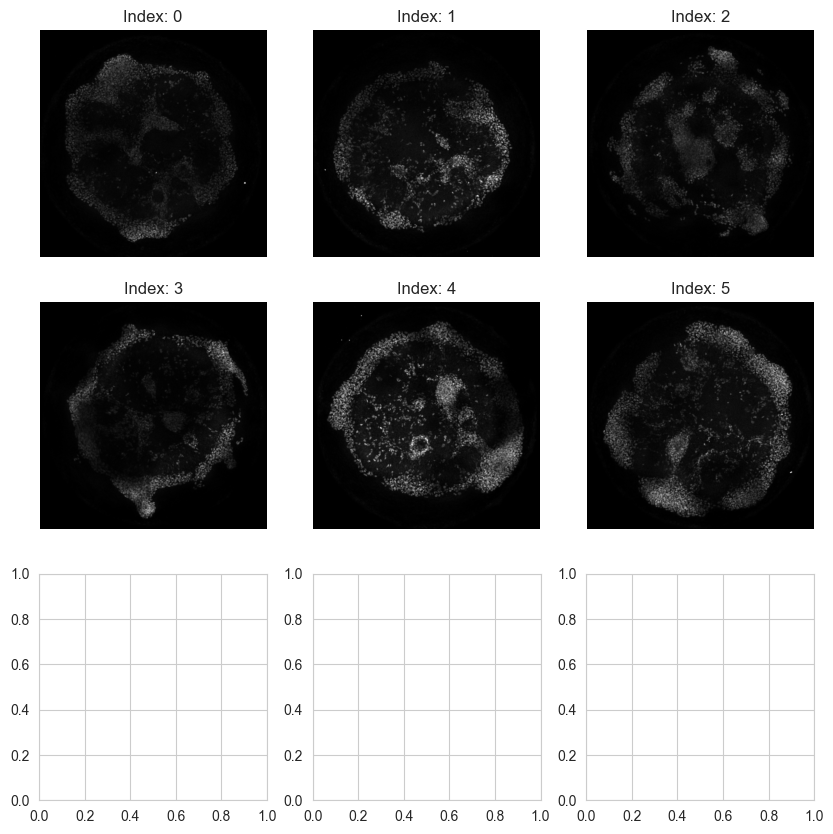

In [95]:
im800 = images[:8]
im900 = images[5:11]
plot_images(list(map(
    lambda x: maximise_img_channels(x),
    im900
)), 0)

In [7]:
del file_names[0]
del file_names[4:6]
del images[0]
del images[4:6]

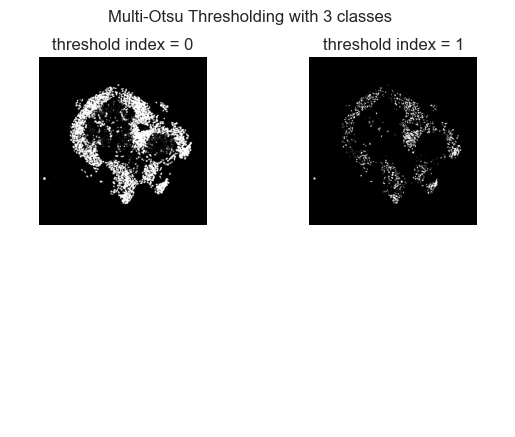

In [8]:
plot_multi_otsu_thresholds(maximise_img_channels(images[0]), 0, 3)

In [9]:
from toolz import pipe

dapi_num = 3

v_new = list(map(
    lambda x:
    pipe(
        x,
        lambda f: maximise_and_normalize(f),
        lambda f: apply_multiotsu_to_image(f, dapi_num),
        lambda f: apply_multiotsu_to_channel(f, 0),
        lambda f: apply_multiotsu_to_channel(f, 1, num_classes=3),
        #lambda f: apply_multiotsu_to_channel(f, 2),
    ),
    images)
)

print(f'Original shape:\t{images[0].shape}')
print(f'New shape:\t{v_new[0].shape}')

Original shape:	(3, 4, 1024, 1024)
New shape:	(4, 1024, 1024)


### Image Processing

In [10]:
def gen_channel_names(file):
    file_params = os.path.basename(file).split("_")
    channel_names = file_params[6:12][::2]
    channel_names = list(map(lambda x: x.upper(), channel_names))
    channel_names.append("DAPI")
    return channel_names


def mp_type(file):
    file_params = os.path.basename(file).split("_")
    return file_params[4:5]

In [116]:
df = []

for file, img in zip(file_names, v_new):
    df_mini = generate_data_frame(
        expand_coordinate_matrix(img[dapi_num]),
        img,
        gen_channel_names(file),
        Distances=get_distances(img[dapi_num])
    )
    df_mini = scale_distances(df_mini, file=file)
    df_mini = average_distances(df_mini)
    df_mini = smooth_distances(df_mini, gen_channel_names(file))
    df_mini["MP Type"] = np.repeat(mp_type(file), df_mini.shape[0])
    df.append(df_mini)

df = pd.concat(df)

In [117]:
df.loc[df["SIX1"].isna(), "Staining"] = np.repeat("PAX6", df[df["SIX1"].isna()].shape[0])
df.loc[df["PAX6"].isna(), "Staining"] = np.repeat("SIX1", df[df["PAX6"].isna()].shape[0])

In [118]:
df_long = pd.melt(df, id_vars=["Staining", "Distances", "MP Type"],
                  value_vars=["PAX6", "SOX10", "ISI12", "SIX1"]).reset_index()
df_long = df_long.groupby(["MP Type", "Staining", "Distances", "variable"]).mean()
df_long.reset_index(inplace=True)

In [119]:
def normalize_df(data, fil):
    for f in fil:
        data_filter = (
                (data["MP Type"] == f[0]) &
                (data["Staining"] == f[1]) &
                (data["variable"] == f[2])
        )
        cur_data = data.loc[data_filter, "value"]
        data.loc[data_filter, "value"] = gaussian_filter(cur_data, 10)
        data.loc[data_filter, "value"] = ((cur_data - cur_data.min()) /
                                          (cur_data.max() - cur_data.min()))
    return data

In [120]:
data_filter = np.column_stack((
    np.repeat(np.array([["800um",], ["900um"]]), 8, axis=0),
    np.tile(np.repeat(np.array([["PAX6", ], ["SIX1", ]]), 4), 2),
    np.tile(["ISI12", "SOX10", "PAX6", "SIX1"], 4)
))
normalize_df(df_long, data_filter)

,MP Type,Staining,Distances,variable,index,value
0,800um,PAX6,0.000000,ISI12,81072.6,1.000000
1,800um,PAX6,0.000000,PAX6,1504.6,0.000000
2,800um,PAX6,0.000000,SIX1,120856.6,NaN
3,800um,PAX6,0.000000,SOX10,41288.6,1.000000
4,800um,PAX6,0.830266,ISI12,81073.6,0.872054
...,...,...,...,...,...,...
24675,stencil,SIX1,630.171758,SOX10,76578.0,0.000000
24676,stencil,SIX1,631.002024,ISI12,116363.0,0.000000
24677,stencil,SIX1,631.002024,PAX6,36795.0,NaN
24678,stencil,SIX1,631.002024,SIX1,156147.0,0.000000


<Axes: xlabel='Distances', ylabel='value'>

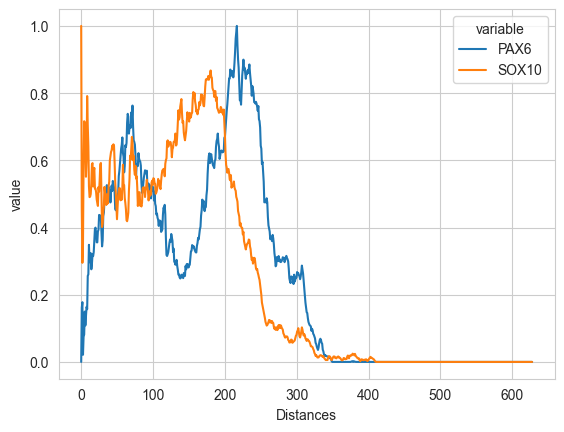

In [121]:
data = df_long.loc[
    (df_long["Staining"] == "PAX6") & 
    (df_long["MP Type"] == "800um") &
    (df_long["variable"].isin(["PAX6", "SOX10"]))
]
sns.lineplot(data=data,
             x="Distances",
             y="value",
             hue="variable")

<Axes: xlabel='Distances', ylabel='value'>

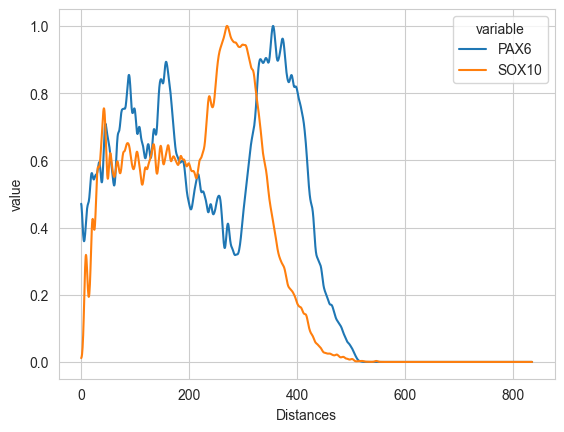

In [111]:
data = df_long.loc[
    (df_long["Staining"] == "PAX6") & 
    (df_long["MP Type"] == "900um") &
    (df_long["variable"].isin(["PAX6", "SOX10"]))
]
sns.lineplot(data=data,
             x="Distances",
             y="value",
             hue="variable")

KeyboardInterrupt: 

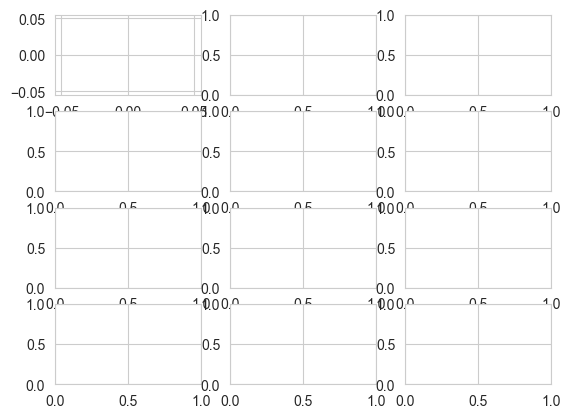

In [23]:
fig, axes = plt.subplots(1, 3)

channel_names = gen_channel_names(file_names[0])
channel_names[3] = "SIX1"
channel_names = np.repeat(channel_names, 3)
mp_types = np.tile(["800um", "900um", "stencil"], 4)

for ax, channel, typ in zip(axes.flat, channel_names, mp_types):
    df_sub = df[df["MP Type"] == typ]
    df_sub.reset_index(inplace=True)
    g = sns.lineplot(data=df_sub, x="Distances", y=channel, ax=ax)
    #ax.set_xlim(0, pos_map.get(pos) / 2)
    ax.set_ylabel("Average Intensity [au]")
    ax.set_xlabel("")
    pos = ax.get_position()
    ax.text(pos.x0 - 0.25, pos.y0 + 0.25, channel)
plt.show()